### Import Libraries

In [144]:
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### 1. Pre-processing

In [145]:
sample_rate = 16000
frame_length = int(0.032 * sample_rate)  # 32ms
hop_length = frame_length//2    # 16ms

In [146]:
def select_cry_frames_using_energy(signal: np.ndarray, frame_length, hop_length, thresh=0.1) -> list:
    energy = np.array([
        sum(abs(signal[i:i+frame_length]**2))
        for i in range(0, len(signal), hop_length)
    ])
    energy_norm = energy / max(energy)
    index_cry = [i for i in range(len(energy)) if energy_norm[i] >= thresh]
    return index_cry

def split_segments(index_voices: list, hop_length, sr, min_duration=0.2) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return [(start, end) for start, end in segments if (end - start) * hop_length / sr >= min_duration]

### 2. Features Extraction

In [147]:
def extract_features(signal, sr, n_mfcc=12, n_fft=2048):
    # Trích xuất MFCC (Mel Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    mfccs_mean = np.mean(mfccs, axis=1)  # Trả về giá trị trung bình của MFCC qua toàn bộ tín hiệu
    
    # Trích xuất RMS (Root Mean Square)
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)
    rms_mean = np.mean(rms)  # Trả về giá trị trung bình của RMS
    
    # Trích xuất Zero-Crossing Rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length)
    zcr_mean = np.mean(zcr)  # Trả về giá trị trung bình của Zero-Crossing Rate
    
    # Trả về tất cả các đặc trưng: MFCCs, RMS, và Zero-Crossing Rate
    return np.concatenate([mfccs_mean, [rms_mean], [zcr_mean]])

In [148]:
data_dir = 'data_augmentation'

for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    
    if os.path.isdir(class_dir):
        file_count = len(os.listdir(class_dir)) 
        print(f"Lớp {label} có {file_count} file.")

Lớp belly_pain có 36 file.
Lớp burping có 27 file.
Lớp discomfort có 36 file.
Lớp hungry có 36 file.
Lớp tired có 42 file.


In [149]:
X = []
y = []

# Duyệt qua từng lớp
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        
        # Load file âm thanh
        signal, sr = librosa.load(file_path, sr=16000)
        
        # Chọn các frame chứa tiếng khóc dựa vào năng lượng chuẩn hóa
        index_cry = select_cry_frames_using_energy(signal, frame_length, hop_length)
        
        # Chia các frame thành các segment
        segments = split_segments(index_cry, hop_length, sr)
        
        # Trích xuất đặc trưng cho từng segment
        for (start, end) in segments:
            segment = signal[start * hop_length : end * hop_length]
            features = extract_features(segment, sr)
            X.append(features)
            y.append(label)

In [150]:
print("Kích thước của X:", np.shape(X))
print("Kích thước của y:", np.shape(y))

Kích thước của X: (423, 14)
Kích thước của y: (423,)


### 3. Train Test Split

In [151]:
# Chuyển đổi nhãn sang dạng số
le = LabelEncoder()
y = le.fit_transform(y)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [152]:
print("Kích thước của X_train:", np.shape(X_train))
print("Kích thước của X_test:", np.shape(X_test))
print("Kích thước của y_train:", np.shape(y_train))
print("Kích thước của y_test:", np.shape(y_test))

Kích thước của X_train: (296, 14)
Kích thước của X_test: (127, 14)
Kích thước của y_train: (296,)
Kích thước của y_test: (127,)


### 4. Training Model

Model: Random Forest, Accuracy: 0.905512, F1 score: 0.903386
Model: Bagged Tree, Accuracy: 0.874016, F1 score: 0.869964
Model: KNN, Accuracy: 0.740157, F1 score: 0.742864
Model: SVM, Accuracy: 0.708661, F1 score: 0.701052
       Algorithm  Accuracy Score  F1 Score
0  Random Forest        0.905512  0.903386
1    Bagged Tree        0.874016  0.869964
2            KNN        0.740157  0.742864
3            SVM        0.708661  0.701052


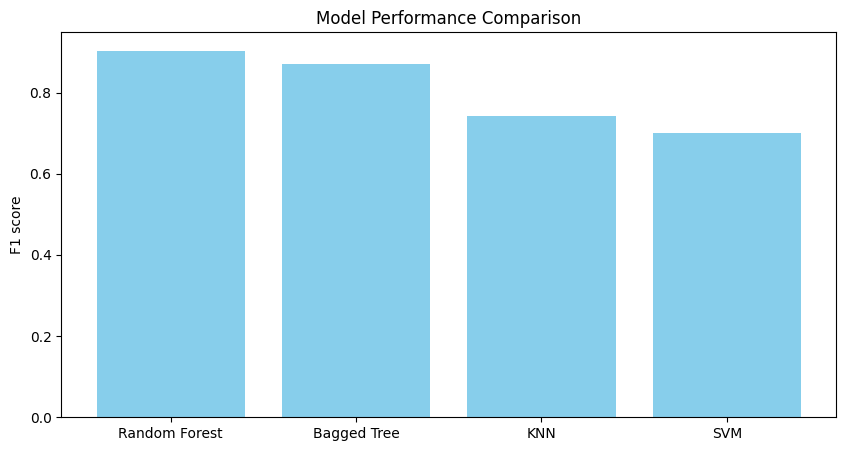

In [153]:
# Huấn luyện và đánh giá mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Bagged Tree': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100),
    'KNN':  KNeighborsClassifier(n_neighbors=4),
    'SVM': SVC(kernel='linear', C=1, random_state=42),
}

results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {f1:.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})


results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

#### Confusion matrix

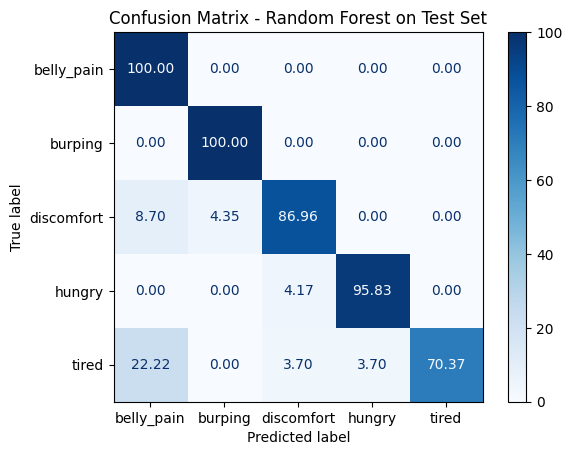

In [154]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort', 'hungry','tired'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()